In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Library for boxplots
import seaborn as sns
#ahmed

L'objectif de ce notebook est d'analyser des données sur le Champions League fourni par l'UEFA. 

In [87]:
key_stats = pd.read_csv('key_stats.csv')
attacking = pd.read_csv('attacking.csv')
defending = pd.read_csv('defending.csv')
attempts = pd.read_csv('attempts.csv')
disciplinary = pd.read_csv('disciplinary.csv')
distributon = pd.read_csv('distributon.csv')
goalkeeping = pd.read_csv('goalkeeping.csv')
goals = pd.read_csv('goals.csv')

En analysant directement les CSV, pn voit qu'il y a énormément de données très variées. Cependant, il n'y a aucun ratio "par match" et très peu de statistiques sur la précision. Ainsi, nous avons décidé de créer quelques variables :

In [88]:
# feature engineering

attempts['attempts_accuracy'] = 100 * attempts['on_target'] / attempts['total_attempts']
defending['tackles_accuracy'] = 100* defending['t_won'] / defending['tackles']
defending['balls_recoverd_per_match'] = defending['balls_recoverd'] / defending['match_played']
goals['goals_per_match'] = goals['goals'] / goals['match_played']
goalkeeping['gk_accuracy'] = 100 * goalkeeping['saved'] / (goalkeeping['saved']+goalkeeping['conceded'])
goalkeeping['cleansheets_rate'] = 100 * goalkeeping['cleansheets'] / goalkeeping['match_played']
defending['tackles_per_match'] = defending['tackles'] / defending['match_played']
goalkeeping['saved_per_match'] = goalkeeping['saved'] / goalkeeping['match_played']
attempts['attempts_per_match'] = attempts['total_attempts'] / attempts['match_played']

Ensuite, on propose de joindre tous ces csv sur le nom du joueur. Ainsi, pour chaque joueur, on aura ses statistiques provenant de tous les csv. Cependant, il se peut que certains joueurs n'apparaissent pas dans tous les csv (exemple : Courtois n'apparaît pas dans goals). On traitera ce problème plus tard.

In [89]:
# merged dataframe

dataframes = [key_stats, attacking, defending, attempts, disciplinary, distributon, goalkeeping, 
              goals]

df = dataframes[0]

for data in dataframes[1:]:
    df = pd.merge(df, data, on='player_name', how='outer', suffixes=('', '_duplicate'))

df = df.loc[:, ~df.columns.str.endswith('_duplicate')]
df = df.loc[:, ~df.columns.str.contains('serial')]
df.head()

,player_name,club,position,minutes_played,match_played,goals,assists,distance_covered,corner_taken,offsides,...,cleansheets_rate,saved_per_match,right_foot,left_foot,headers,others,inside_area,outside_areas,penalties,goals_per_match
0,Aaronson,Salzburg,Midfielder,715.0,8.0,0.0,2.0,103.5,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Abubakari,Malmö,Forward,116.0,4.0,0.0,0.0,15.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Acuña,Sevilla,Defender,379.0,5.0,0.0,0.0,43.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adams,Leipzig,Midfielder,292.0,5.0,0.0,0.0,38.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adamu,Salzburg,Forward,231.0,8.0,1.0,0.0,32.6,NaN,NaN,...,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.125


In [90]:
df['position'].unique()

array(['Midfielder', 'Forward', 'Defender', 'Goalkeeper', nan],
      dtype=object)

In [91]:
df[df["position"].isna()]

,player_name,club,position,minutes_played,match_played,goals,assists,distance_covered,corner_taken,offsides,...,cleansheets_rate,saved_per_match,right_foot,left_foot,headers,others,inside_area,outside_areas,penalties,goals_per_match
88,Burak Yilmaz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
df_sans_ligne = df.drop(index=88)

In [93]:
df = df.drop(columns=['others'])

In [94]:
df_sans_ligne['position'].unique()

array(['Midfielder', 'Forward', 'Defender', 'Goalkeeper'], dtype=object)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_name               1003 non-null   object 
 1   club                      1002 non-null   object 
 2   position                  1002 non-null   object 
 3   minutes_played            1002 non-null   float64
 4   match_played              1002 non-null   float64
 5   goals                     1002 non-null   float64
 6   assists                   1002 non-null   float64
 7   distance_covered          1002 non-null   object 
 8   corner_taken              328 non-null    float64
 9   offsides                  328 non-null    float64
 10  dribbles                  328 non-null    float64
 11  balls_recoverd            888 non-null    float64
 12  tackles                   888 non-null    float64
 13  t_won                     888 non-null    float64
 14  t_lost  

Ainsi, notre data set final fait 1003 lignes (joueurs), toutes décrites par 52 colonnes. On peut voir les valeurs manquantes plus hauts. Pour gérer ce problème, on va tout remplir par des 0. En effet, si un joueur n'apparait pas dans un csv, cela veut dire qu'il n'a aucune statistiques prévu dans ce data set.

En reprenant l'exemple précédent, Thibaut Courtois, étant un gardien, n'apparaît pas dans goals car il n'a marqué aucun but. Il n'apparait pas non plus dans attempts car il n'a même pas essayé de tirer. Ce raisonnement marche en réalité pour tous les joueurs. Ainsi, il n'est pas aberrant de mettre que courtois a une précision de tir de 0%, qu'il a marqué 0 but, etc

In [96]:
df = df.fillna(value=0)

In [97]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
minutes_played,1003.0,341.809571,239.265277,0.0,137.500000,326.000000,499.500000,1230.000
match_played,1003.0,5.189432,2.648392,0.0,3.000000,5.000000,7.000000,13.000
goals,1003.0,0.427717,1.165672,0.0,0.000000,0.000000,0.000000,15.000
assists,1003.0,0.362911,0.821311,0.0,0.000000,0.000000,0.000000,7.000
corner_taken,1003.0,0.705882,3.045928,0.0,0.000000,0.000000,0.000000,36.000
offsides,1003.0,0.249252,1.083208,0.0,0.000000,0.000000,0.000000,10.000
dribbles,1003.0,2.073779,5.816432,0.0,0.000000,0.000000,2.000000,83.000
balls_recoverd,1003.0,15.947159,15.526110,0.0,4.000000,12.000000,23.000000,76.000
tackles,1003.0,4.695912,4.837505,0.0,1.000000,3.000000,8.000000,35.000
t_won,1003.0,1.943170,2.403790,0.0,0.000000,1.000000,3.000000,18.000


c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\eloua\AppData\Local\Programs\Python\Python310

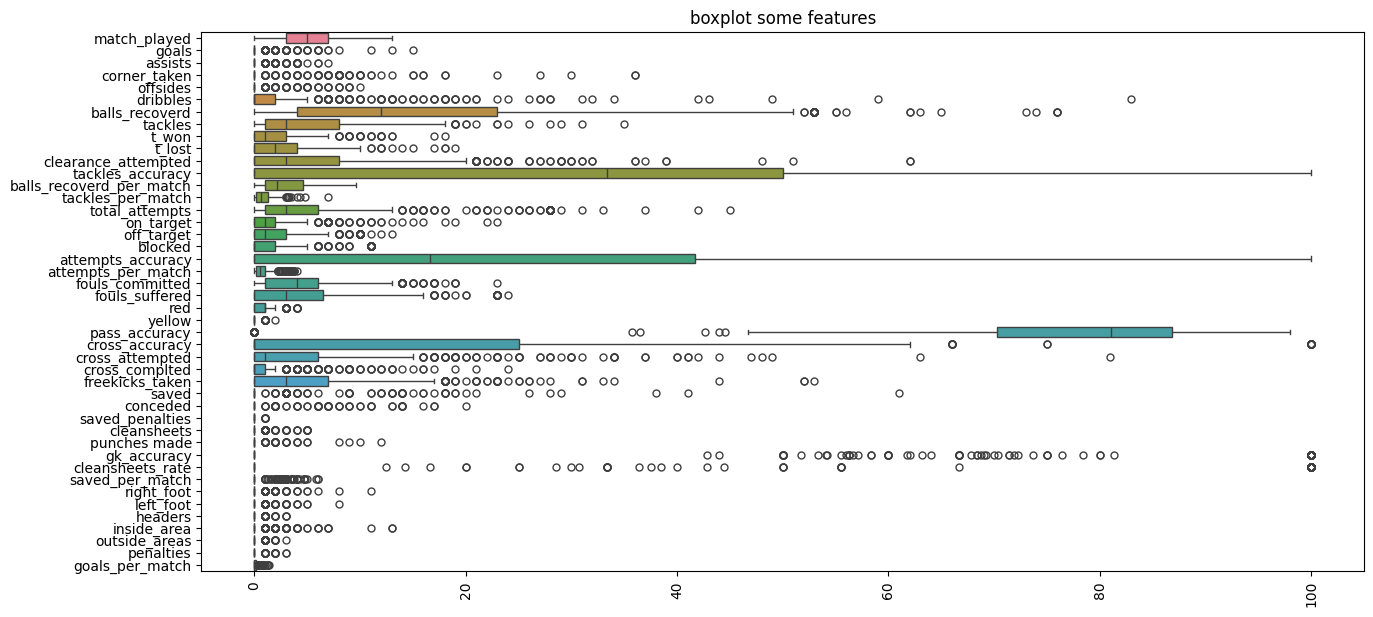

In [98]:
plt.figure(figsize=((15,7)))
plt.title('boxplot some features')
data = df.drop(columns=['minutes_played', 'pass_attempted', 'pass_completed'])
food_box=sns.boxplot(data=data,fliersize=5, orient='h')
plt.xticks(rotation=90)
plt.show()

c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\eloua\AppData\Local\Programs\Python\Python310

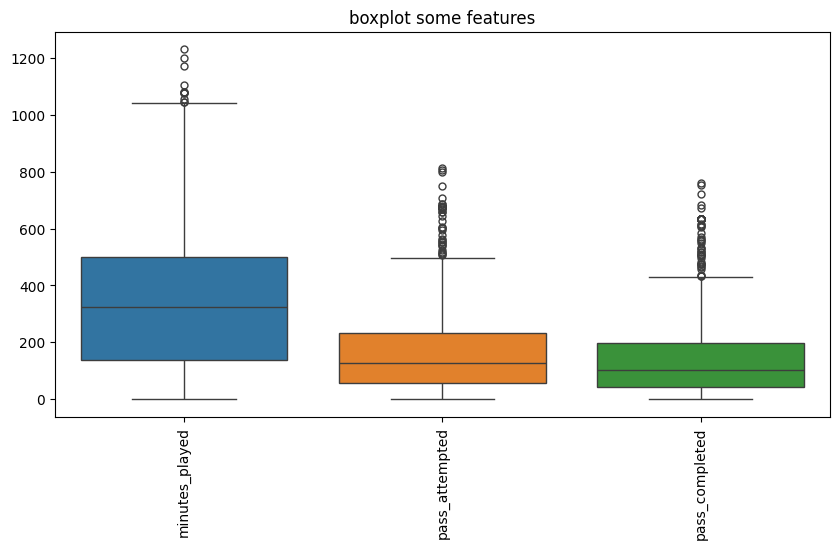

In [99]:
plt.figure(figsize=((10,5)))
plt.title('boxplot some features')
data = df[['minutes_played', 'pass_attempted', 'pass_completed']]
food_box=sns.boxplot(data=data,fliersize=5)
plt.xticks(rotation=90)
plt.show()

Avec le tableau et les boxplot précédents, on peut remarquer plusieurs choses : 
- il y a des échelles différentes, donc il faudra absolument les standardiser pour entrainer de futurs modèles
- il y a beaucoup de outliers, notamment des valeurs qui sont beaucoup trop grandes par rapport aux autres
- on voit aussi une différence dans la manière dont les variables sont distribués (certaines variables sont très concentrées autour de leur moyenne, comme goals, et d'autres non, comme attemps_accuracy, qui pourront être intéressantes pour un PCA)

# Factorial analysis

Commencons par afficher les corrélations entre les variables. Pour plus de visibilité, on commence par les afficher csv par csv puis on finira par le data set final.

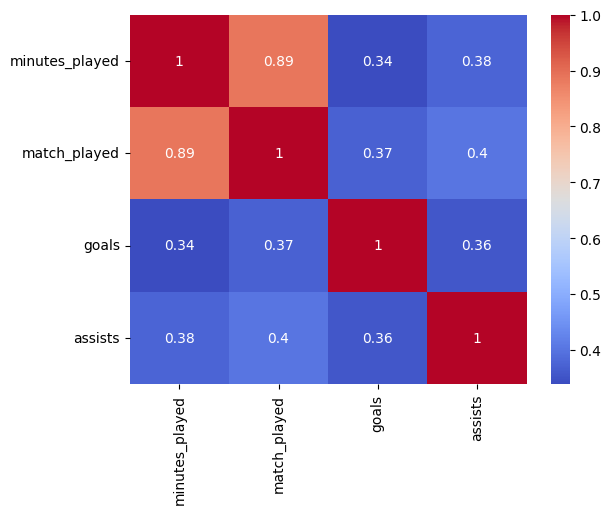

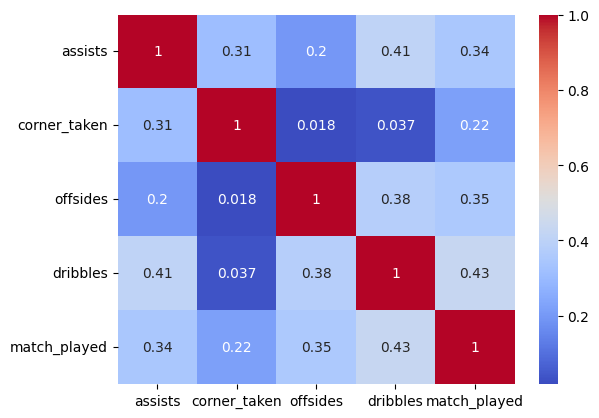

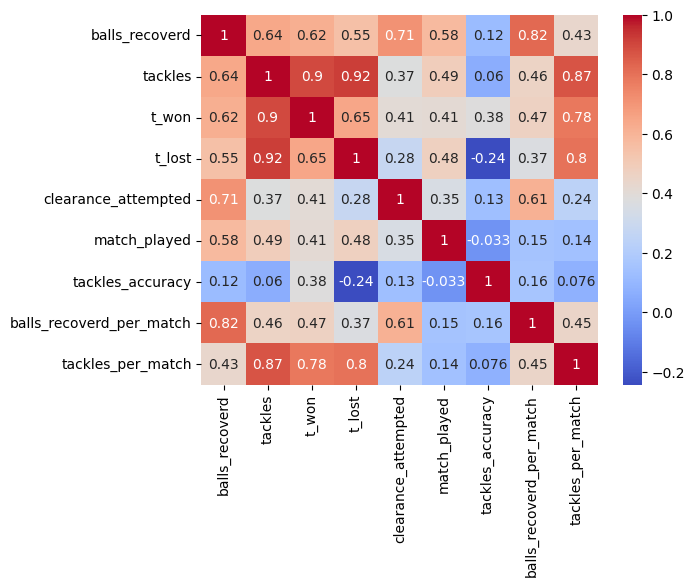

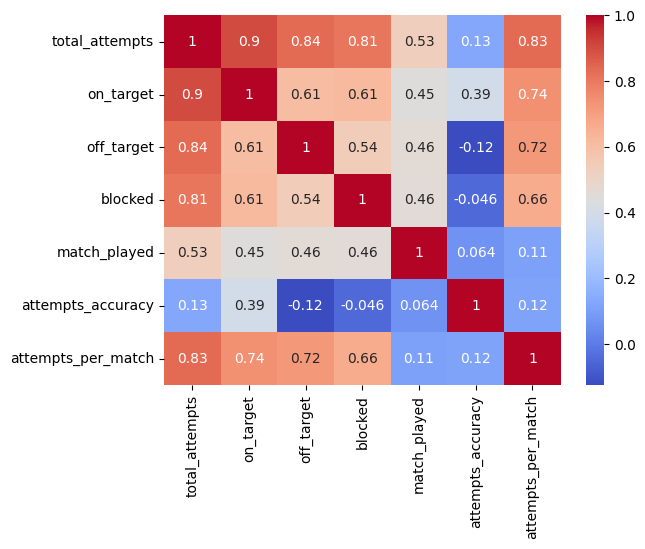

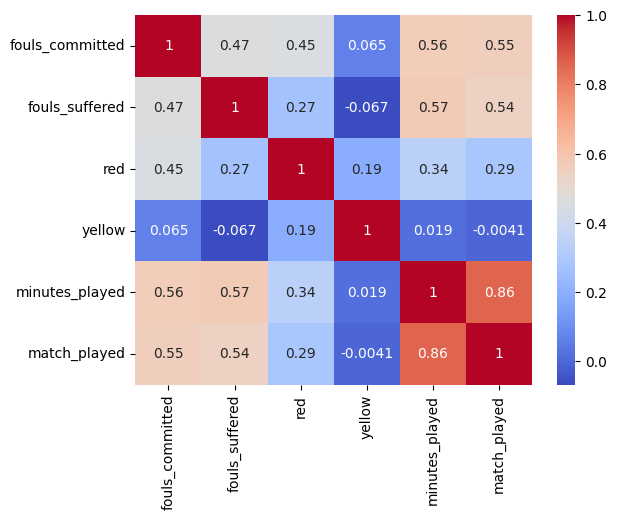

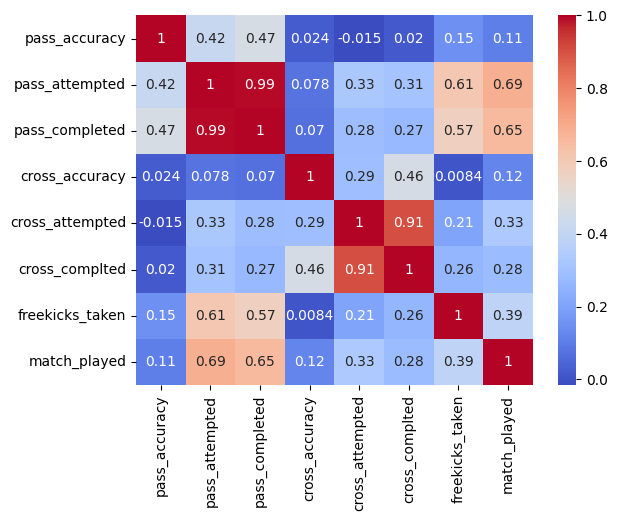

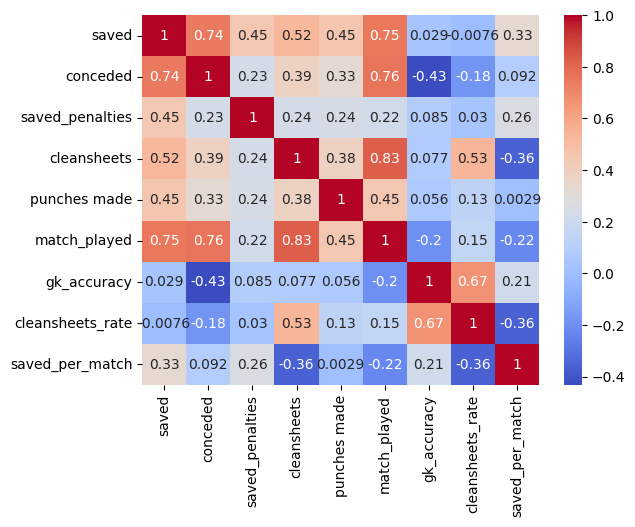

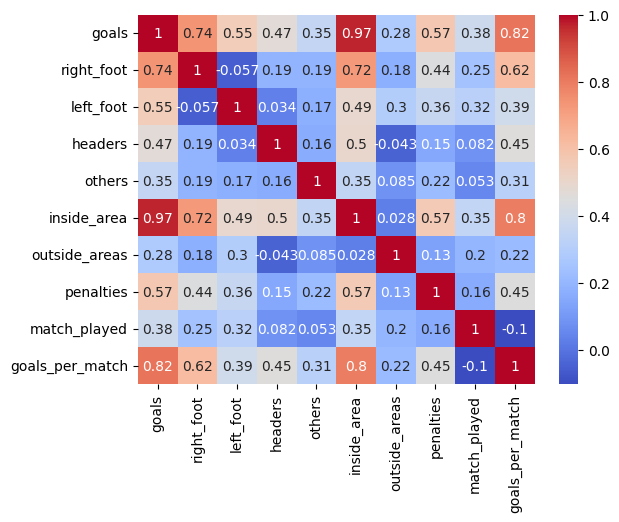

In [100]:
for data in dataframes:
    if 'serial' in data.columns:
        data = data.drop(columns=['serial'])
    corr = data.select_dtypes(exclude='object').corr()
    if corr.shape[0] > 1 and not corr.isnull().all().all():
        plt.figure()
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.show()
    else:
        print("La matrice de corrélation est vide ou n'a qu'une seule colonne.")

<Axes: xlabel='pass_attempted', ylabel='pass_completed'>

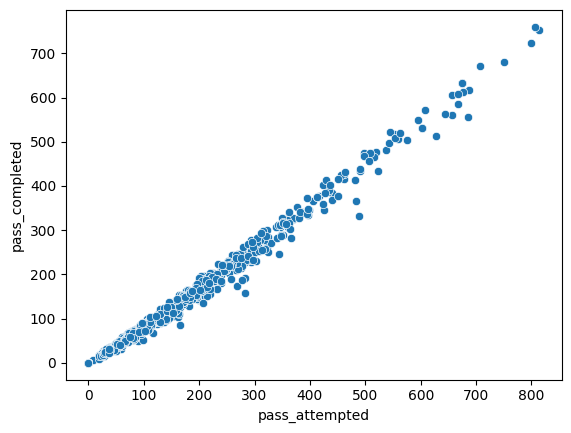

In [101]:
sns.scatterplot(df, x='pass_attempted', y='pass_completed')

<Axes: >

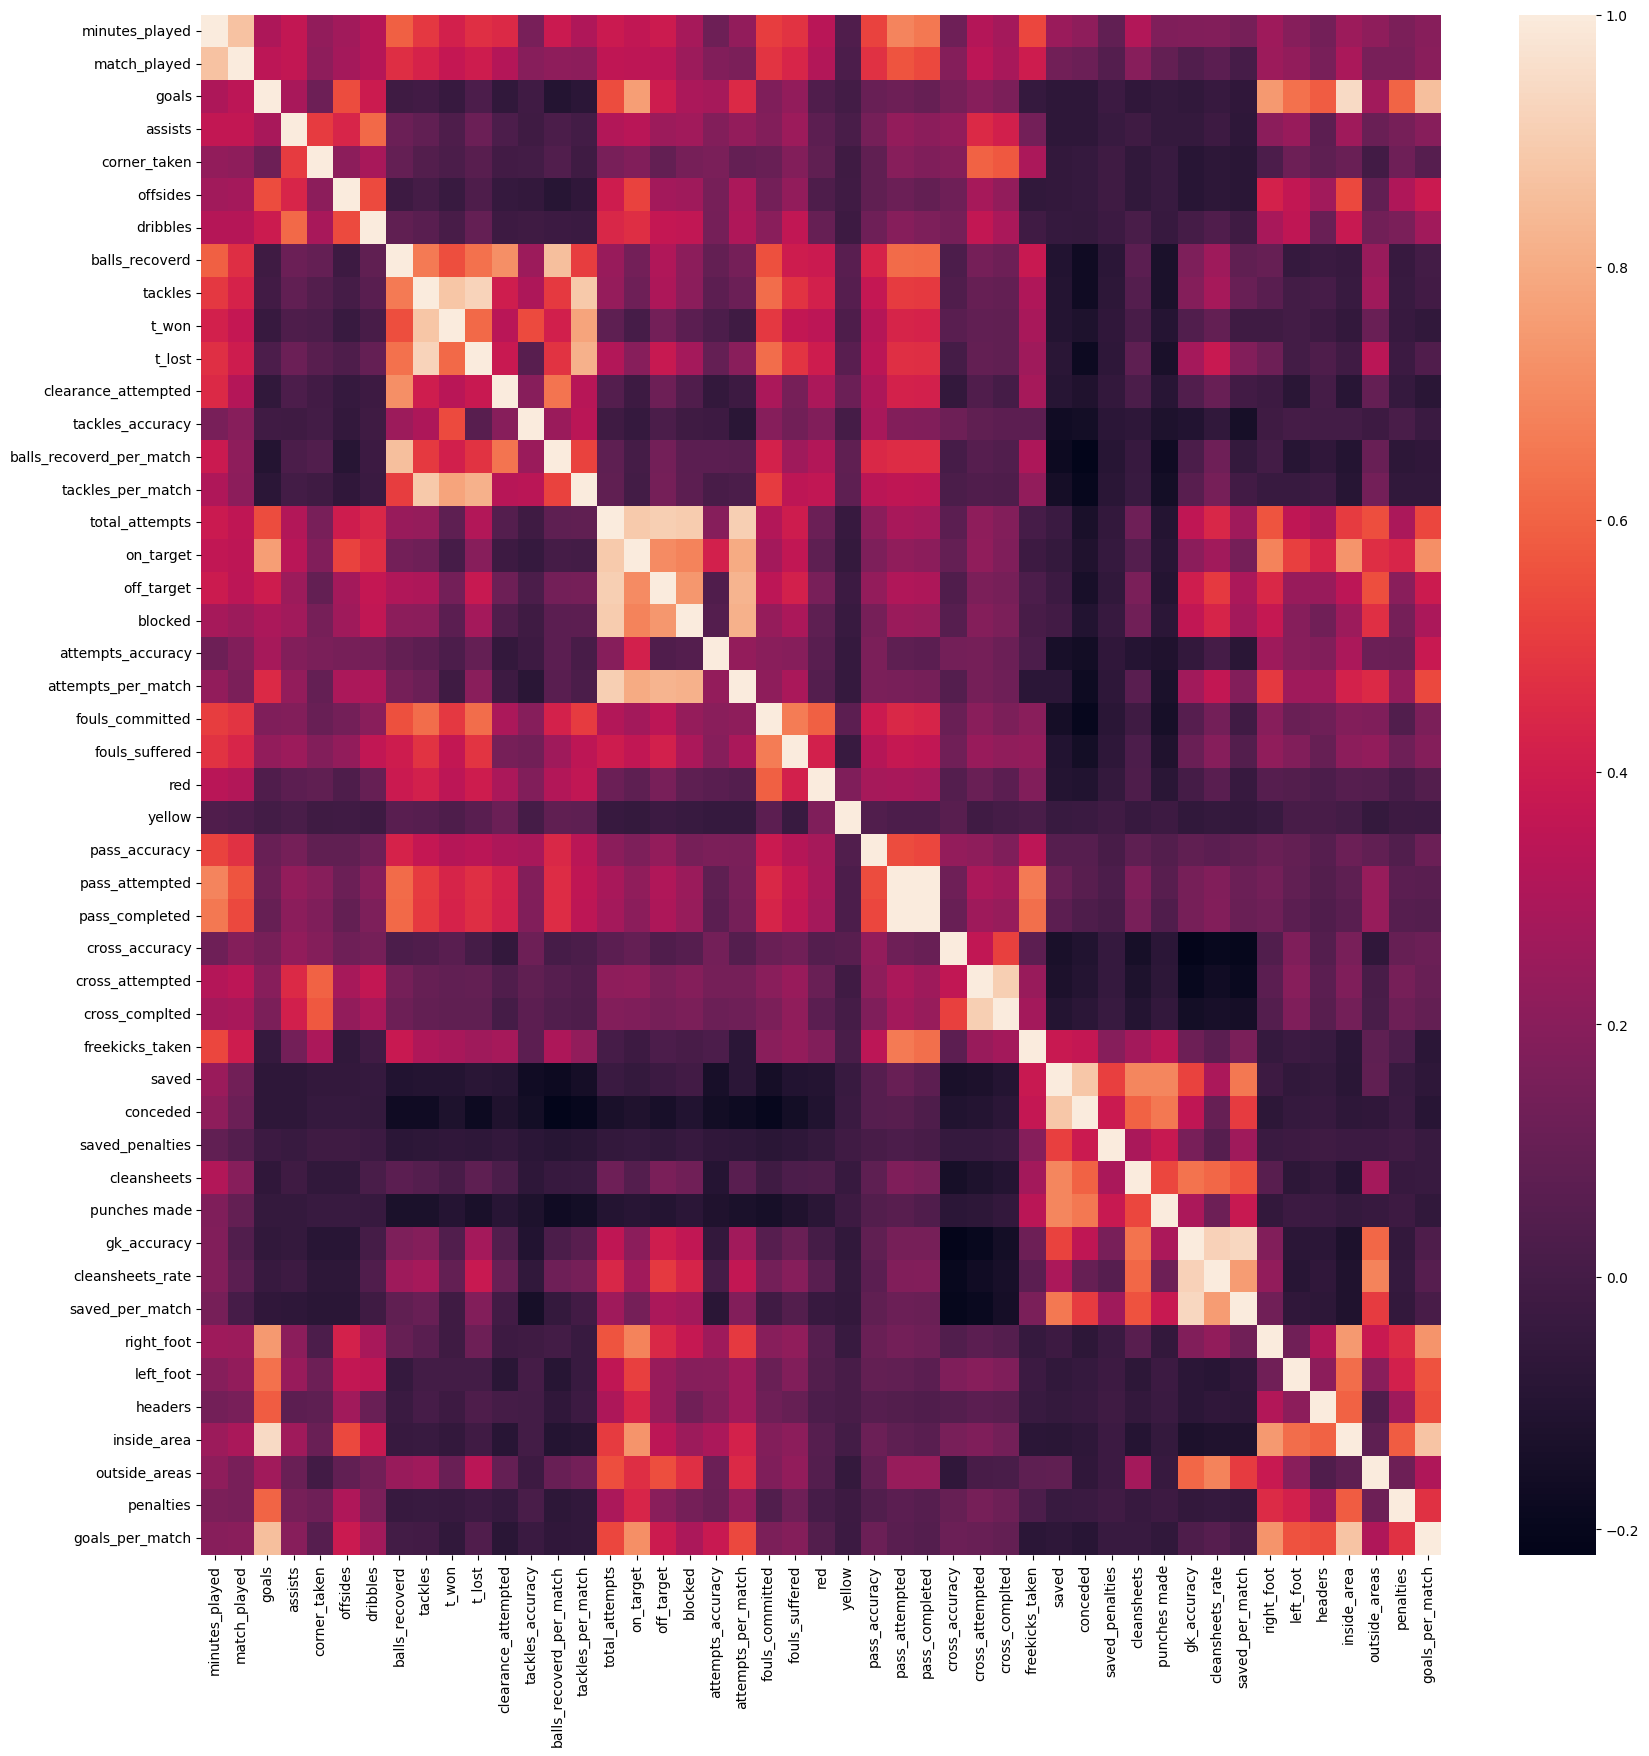

In [102]:
corr = df.select_dtypes(exclude='object').corr()
plt.figure(figsize=((20,20)))
sns.heatmap(corr)

On remarque qu'il y a quelques variables qui sont corrélés, comme: 
- pass_completed / pass_attempted (on a d'ailleurs afficher le graphe)
- goals / insied_area
- cross_completed / cross_attempted 
etc

Ainsi, avec ces quelques variables corrélées, on peut espérer une réduction de quelques dimensions lorsque nous appliquerons des modeles de réduction de la dimension. Cependant, il y a trop de peu de corrélation pour espérer réduire drastiquement le nombre de dimension.

# PCA

Voyons ce qu'un PCA peut faire sur notre data set.

In [103]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import mean_squared_error

In [104]:
X = df.select_dtypes(exclude='object').values
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [105]:
X.shape

(1003, 47)

In [106]:
pca = PCA(n_components=X.shape[1]).fit(X_scaled)

In [107]:
np.cumsum(pca.explained_variance_ratio_)

array([0.22467396, 0.36613912, 0.47973757, 0.55710832, 0.60940996,
       0.642297  , 0.67022359, 0.69529341, 0.71865214, 0.74130659,
       0.76263489, 0.78187715, 0.80049192, 0.81797203, 0.83436888,
       0.85026623, 0.86431751, 0.8779549 , 0.88956651, 0.90096696,
       0.91160293, 0.9216095 , 0.93081565, 0.9393668 , 0.94734565,
       0.95475454, 0.96132992, 0.96715589, 0.97218635, 0.9769418 ,
       0.98114987, 0.98492905, 0.98776478, 0.99024808, 0.99199085,
       0.99356898, 0.99497997, 0.99623474, 0.99737529, 0.99840867,
       0.9990938 , 0.99970991, 0.99993524, 0.99997181, 1.        ,
       1.        , 1.        ])

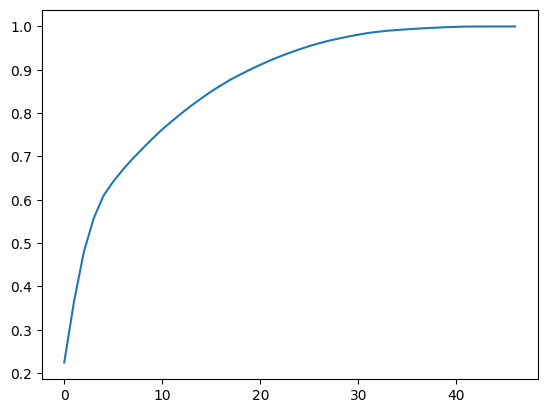

In [108]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

Comme nous l'avions prévu, on peut réduire d'une dizaine de dimension (en gardant les 33 premières dimensions au lieu des 48 colonnes numériques) en expliquant 99% de la variance. Essayons de voir si les premières dimensions sont corrélés avec nos variables.

Variable la plus corrélée: total_attempts
Corrélation: 0.7735


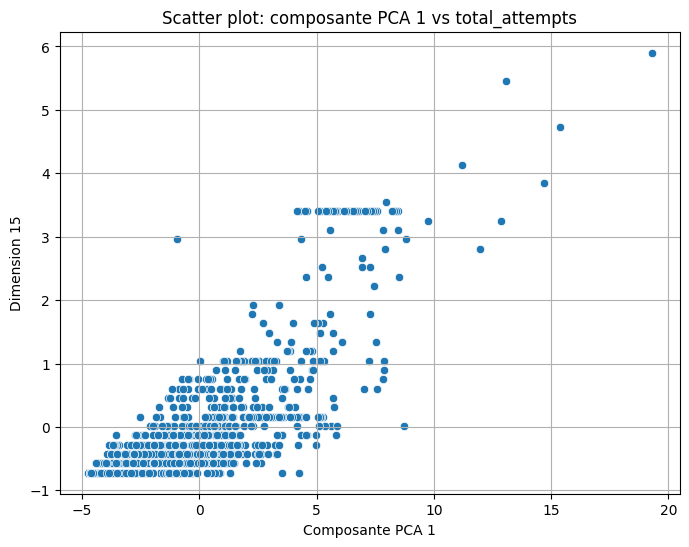

Variable la plus corrélée: inside_area
Corrélation: 0.6838


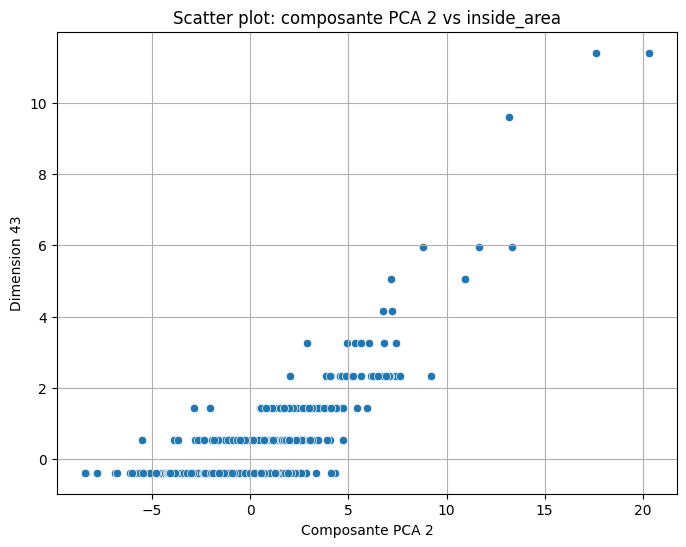

Variable la plus corrélée: saved_per_match
Corrélation: 0.8592


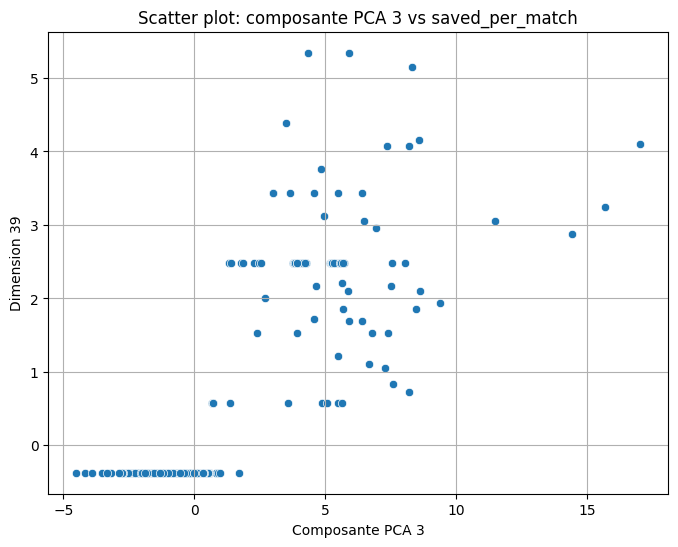

Variable la plus corrélée: conceded
Corrélation: 0.5526


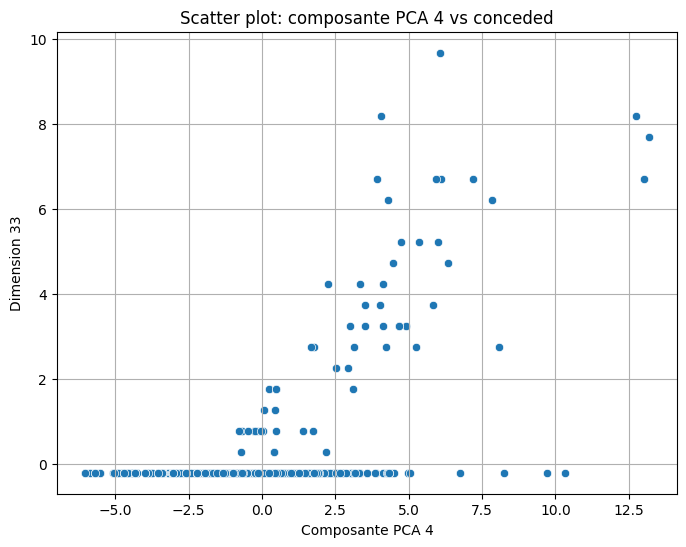

Variable la plus corrélée: cross_complted
Corrélation: 0.5024


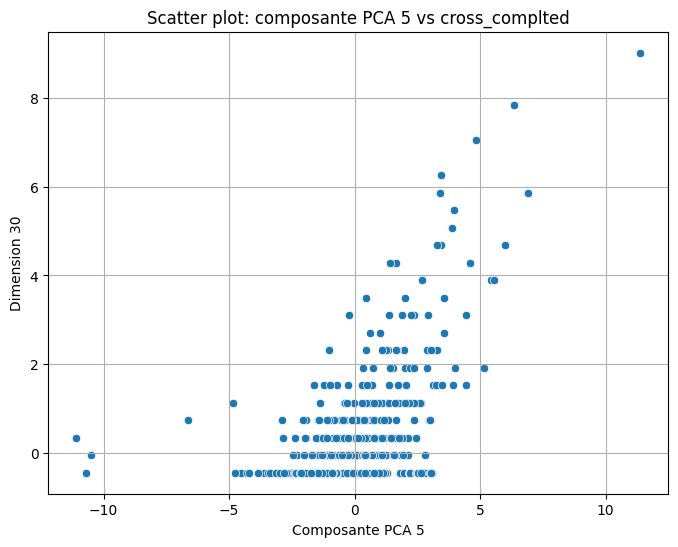

In [109]:
pca = PCA(n_components=X.shape[1])  
X_pca = pca.fit_transform(X_scaled)
numeric_columns = df.select_dtypes(exclude='object').columns

for j in range(5):
    pca_component = X_pca[:, j]
    correlations = []
    for i in range(X_scaled.shape[1]):
        corr = np.corrcoef(pca_component, X_scaled[:, i])[0, 1]
        correlations.append(corr)

    best_index = np.argmax(np.abs(correlations))
    best_corr = correlations[best_index]
    best_column_label = numeric_columns[best_index]

    print(f"Variable la plus corrélée: {best_column_label}")
    print(f"Corrélation: {best_corr:.4f}")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=pca_component, y=X_scaled[:, best_index])
    plt.title(f"Scatter plot: composante PCA {j+1} vs {best_column_label}")
    plt.xlabel(f'Composante PCA {j+1}')
    plt.ylabel(f'Dimension {best_index}')
    plt.grid(True)
    plt.show()

Les corrélations entre les premières dimensions et les variables sont assez pauvres.

# FA

Tentons une autre méthode de réduction de dimension :D

Nous avons donc essayé la méthode FA ne cherche pas à optimiser la variance (comme le PCA) mais cherche plutot à reproduire la structure de covariance dans un ensemble de dimension plus restreint. Ainsi, pour tester son efficacité, on peut lire les erreurs entre les données originales et les données reconstruites.

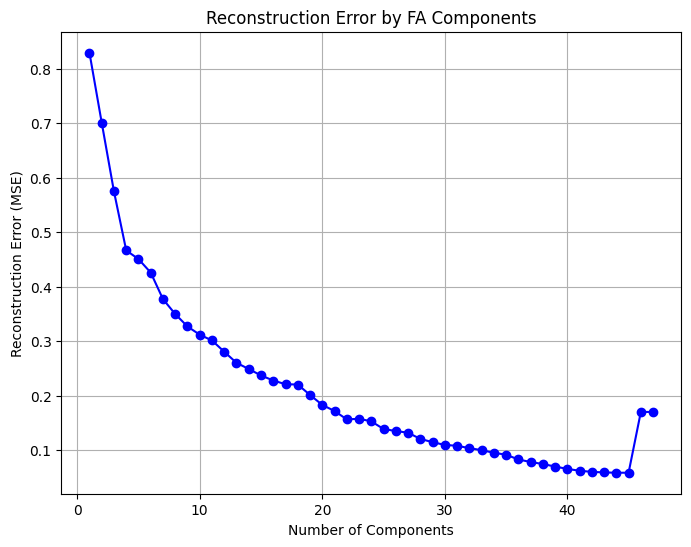

In [110]:
def reconstruction_error_by_fa_components(X, max_components=10):
    # Liste pour stocker les erreurs de reconstruction
    reconstruction_errors = []

    # Tester différents nombres de composants de 1 à max_components
    for n_components in range(1, max_components + 1):
        # Appliquer l'analyse factorielle avec n_components
        fa = FactorAnalysis(n_components=n_components)
        X_transformed = fa.fit_transform(X)

        # Reconstruire les données approximatives en utilisant les facteurs extraits
        X_reconstructed = np.dot(X_transformed, fa.components_) + fa.mean_

        # Calculer l'erreur de reconstruction (erreur quadratique moyenne)
        error = mean_squared_error(X, X_reconstructed)
        reconstruction_errors.append(error)

    # Tracer le graphe
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_components + 1), reconstruction_errors, marker='o', linestyle='-', color='b')
    plt.title('Reconstruction Error by FA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.grid(True)
    plt.show()
    
reconstruction_error_by_fa_components(X_scaled, max_components=X_scaled.shape[1])

En se basant sur ce graphe, on remarque que la méthode de FA n'est pas meilleure que le PCA car l'erreur diminue très lentement, sans apparition d'un coude. Pour 33 dimensions (nombre de dimensions qu'on avait relevé pour le PCA), on a une erreur de 10 % (alors qu'on avait 99% de la variance restituée avec le PCA)

# Clustering

Maintenant, essayons de faire des clusters au sein meme de notre data set.

# K-Means

Commencons par la méthode des K Means.

In [111]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [112]:
# Compute the silhouette index for each cluster number
range_n_clusters = range(2,20)
for n in range_n_clusters:
    clusterer = KMeans(n_clusters=n, n_init=10).fit(X_scaled) 
    cluster_labels = clusterer.labels_ 
    silhouette_avg = silhouette_score(X_scaled, cluster_labels) 
   
    # Display the results
    print("For n =", n, "Silhouette_score:", silhouette_avg)

For n = 2 Silhouette_score: 0.2055661368746336
For n = 3 Silhouette_score: 0.1703876743578213
For n = 4 Silhouette_score: 0.18103505312744336
For n = 5 Silhouette_score: 0.20198832357940263
For n = 6 Silhouette_score: 0.14005785146864283
For n = 7 Silhouette_score: 0.14586951735423936
For n = 8 Silhouette_score: 0.14456026196900426
For n = 9 Silhouette_score: 0.14272887975519424
For n = 10 Silhouette_score: 0.14910112197672723
For n = 11 Silhouette_score: 0.14684430913483865
For n = 12 Silhouette_score: 0.15199482157152627
For n = 13 Silhouette_score: 0.1528503929168715
For n = 14 Silhouette_score: 0.15422552694106187
For n = 15 Silhouette_score: 0.16179225863899394
For n = 16 Silhouette_score: 0.16230252518451035
For n = 17 Silhouette_score: 0.16196608235568044
For n = 18 Silhouette_score: 0.15322417983049139
For n = 19 Silhouette_score: 0.1660724207884054


Le silhouette score est très faible pour tous les essais que nous avons fait (avec 10 initialisations alétoires pour minimiser l'erreur). 
De plus, on constate que la valeur du score est toujours plus ou moins la même, quelque soit le nombre de clusters. Cela suggère que le KNN ne soit pas la méthode la plus adaptée. 
Tentons d'autres approches. 

# Hierarchical

In [113]:
# Functions for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [114]:
# We now perform hierarchical clustering. 

# We apply hierarchical clustering with dissimilarity measure "ward"
Z = linkage(X_scaled, 'ward') 
print(Z)

[[6.50000000e+01 6.71000000e+02 0.00000000e+00 2.00000000e+00]
 [8.50000000e+01 7.96000000e+02 0.00000000e+00 2.00000000e+00]
 [2.70000000e+02 5.51000000e+02 0.00000000e+00 2.00000000e+00]
 ...
 [1.99500000e+03 1.99900000e+03 8.29568073e+01 5.96000000e+02]
 [2.00000000e+03 2.00100000e+03 9.18139290e+01 4.07000000e+02]
 [2.00200000e+03 2.00300000e+03 1.07075762e+02 1.00300000e+03]]


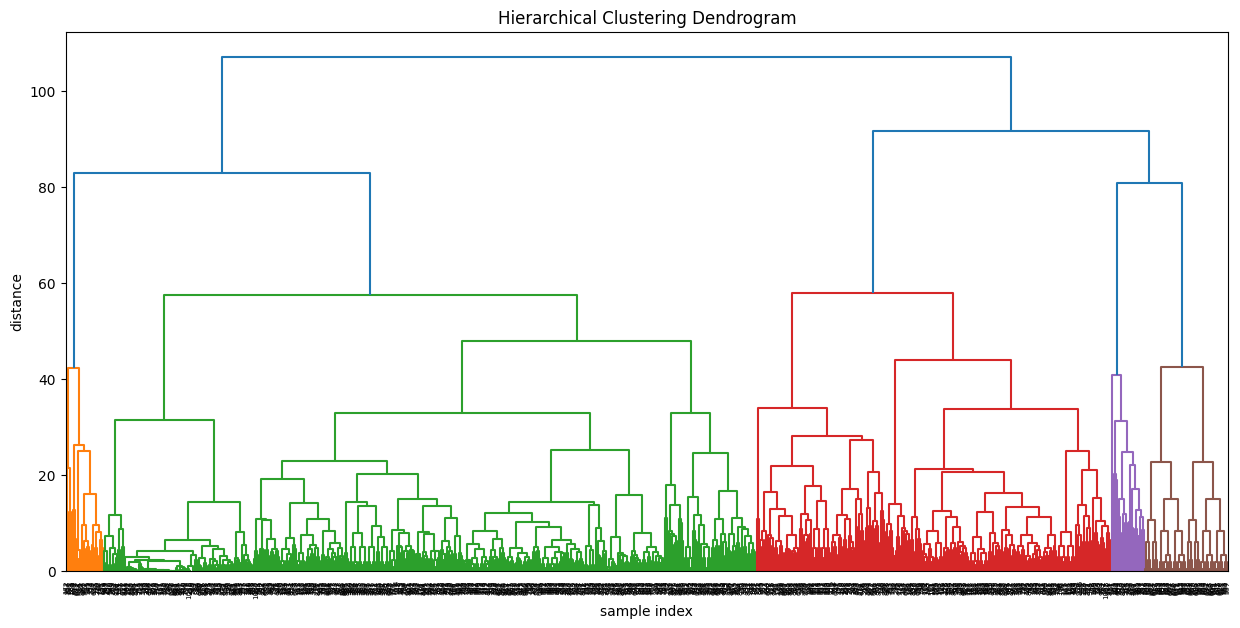

In [115]:
# We represent the corresponding Dendrogram
plt.figure(figsize=(15, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z = linkage(X_scaled, 'ward')
)
plt.xticks(rotation=90)
plt.show()

In [116]:
metrics=['euclidean','hamming', 'cityblock' , 'cosine'] # metrics used for linkage 
methods=['single','complete','average'] # methods used for linkage
pdists=['euclidean','minkowski','cityblock','cosine']  # metrics used for pdist()
max_val=0
best_metric=None
best_method=None
best_p_dist=None

for metric1 in metrics:
    for method1 in methods:
        for pdist1 in pdists:
            Z=linkage(X_scaled,method1,metric=metric1)
            c, coph_dists = cophenet(Z, pdist(X_scaled,pdist1))
            if (c>max_val):
                max_val=c
                best_metric=metric1
                best_method=method1
                best_p_dist=pdist1
            else:
                max_val=max_val
            print('(',method1,',',metric1,',',pdist1,') :',c)
print('the best cophenet index is about :',max_val,'which corresponds to the triple: (metric=',best_metric,',method=',best_method,'and pdist=',best_p_dist,')')

Z_best = linkage(X_scaled, method=best_method, metric=best_metric)
cluster_labels_best = fcluster(Z_best, t=2, criterion='maxclust') 
silhouette_avg_best = silhouette_score(X_scaled, cluster_labels_best, metric=best_metric)
num_clusters = len(np.unique(cluster_labels_best))

# Afficher le Silhouette Score pour la meilleure combinaison
print('The Silhouette Score for the best configuration is:', silhouette_avg_best)
print(f'There are {num_clusters} clusters')

( single , euclidean , euclidean ) : 0.875048745544936
( single , euclidean , minkowski ) : 0.875048745544936
( single , euclidean , cityblock ) : 0.8475827815986325
( single , euclidean , cosine ) : 0.3346821332384725
( complete , euclidean , euclidean ) : 0.7626711708813417
( complete , euclidean , minkowski ) : 0.7626711708813417
( complete , euclidean , cityblock ) : 0.7092640683240061
( complete , euclidean , cosine ) : 0.44497199654500563
( average , euclidean , euclidean ) : 0.9135280594496604
( average , euclidean , minkowski ) : 0.9135280594496604
( average , euclidean , cityblock ) : 0.8561211450929752
( average , euclidean , cosine ) : 0.3647365192119088
( single , hamming , euclidean ) : 0.5758511865142398
( single , hamming , minkowski ) : 0.5758511865142398
( single , hamming , cityblock ) : 0.6999083432703637
( single , hamming , cosine ) : 0.47648334742973353
( complete , hamming , euclidean ) : 0.3239473250521954
( complete , hamming , minkowski ) : 0.3239473250521954


On remarque deja de meilleur resultat. En selectionnant plusieurs combinaisons de parametres pour un clustering par hierarchie, on peut selectionner la meilleure solution en se basant sur le score de cophenet (basé sur les distances présentes dans les dendrogrammes).

Pour comparer au KMeans, on trouve un silhouette score de 0.71 ce qui est bien meilleure que ce que proposait le KMeans (0.2). Pour rappel, le silhouette score calcul à quel point les éléments d'un meme cluster sont similaires et à quel point ils sont différents des éléments des autres clusters. Il serait donc intéressant maintenant de voir à quoi correspond les clusters. Affichons le diagramme : 

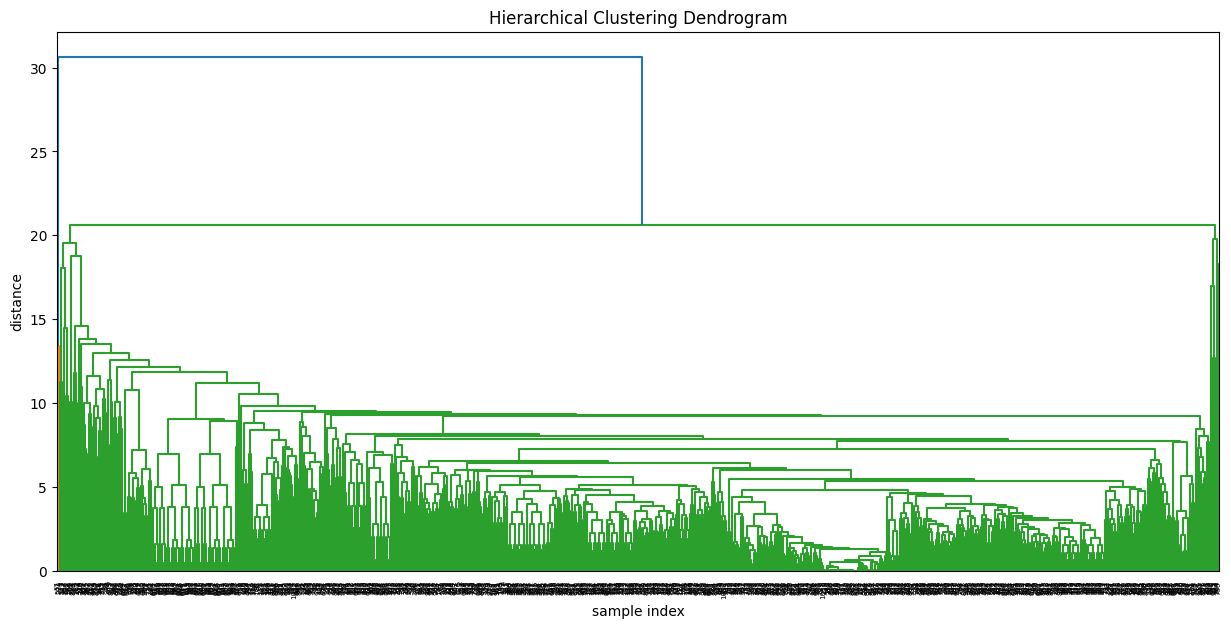

Cluster 1: 2 points
Cluster 2: 1001 points


In [117]:
plt.figure(figsize=(15, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z = Z_best
)
plt.xticks(rotation=90)
plt.show()

cluster_labels_best = fcluster(Z_best, t=2, criterion='maxclust')

# Utiliser np.bincount pour compter le nombre de points dans chaque cluster
counts_per_cluster = np.bincount(cluster_labels_best)

# Afficher le nombre de points dans chaque cluster
for i, count in enumerate(counts_per_cluster):
    if count > 0:  # Ignorer les clusters avec zéro éléments
        print(f'Cluster {i}: {count} points')

On voit que les clusters sont très inégaux dans ce cas la, ce qui est pas intéressant d'un point de vue analyse car quasi toutes les données sont dans le cluster 1.

# TSNE

Ici, nous allons tenter de combiner ce que nous venons de faire : réduire l'espace puis faire des clusters. On commence par utiliser un TSNE qui permet de réduire les dimensions dans le but de les visualiser dans de très petites dimensions (2D, 3D, ...). Cette methode tente de preserver au maximum les relations locales entre les points (s'ils sont initialement proches, ils seront proches dans le nouvelle espace).

On a décidé de faire cela pour pouvoir ensuite visualiser les clusters avec un KMeans.

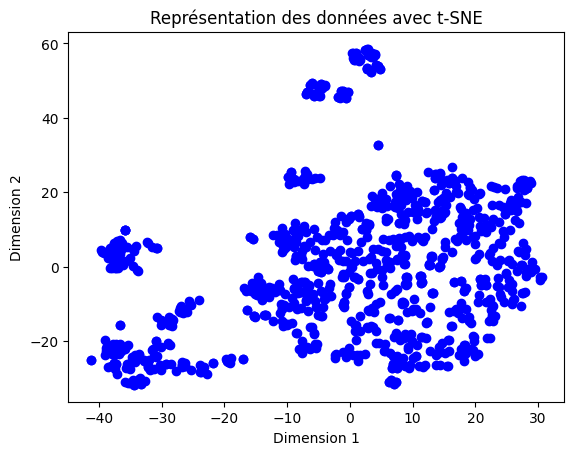

In [118]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=52)

X_tsne=tsne.fit_transform(X_scaled)

#print(X_scaled.shape,X_tsne.shape)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='blue', marker='o')

plt.title('Représentation des données avec t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.show()

Le score de trustworthiness mesure a quel point les relations locales sont conservées (avec 5 voisins ici). Le but ici est de voir si l'on va projeter notre dataset dans un espace en 2D ou en 3D. Comme on le voit dans la cellule ci dessous, on voit que le score de confiance ne varie pas trop entre 2D et 3D, on va donc tout visualiser en 2D qui est beaucoup plus lisible.

De plus, au vu de la qualité de la projection avec l'indice de trustworthiness, tenter de faire des clusters sur cet espace réduit ne parait pas absurde.

In [119]:
from sklearn.manifold import trustworthiness

for i in range(2, 4):
    tsnex = TSNE(n_components=i, learning_rate='auto', init='random',random_state=52)
    X_tsnex = tsnex.fit_transform(X_scaled)
    
    trust = trustworthiness(X_scaled, X_tsnex, n_neighbors=5)
    
    print(f"Trustworthiness score for {i} dimensions: {trust:.2f}")


Trustworthiness score for 2 dimensions: 0.98
Trustworthiness score for 3 dimensions: 0.99


In [120]:
# KMeans sur l'espace reduit
range_n_clusters = range(2,20)
best = {'score' : 0, 'n': 0}
for n in range_n_clusters:
    clusterer = KMeans(n_clusters=n, n_init=10).fit(X_tsne) 
    cluster_labels = clusterer.labels_
    silhouette_avg = silhouette_score(X_tsne, cluster_labels) 
    print("For n =", n, "Silhouette_score:", silhouette_avg)
    if best['score'] < silhouette_avg :
        best['score'] = silhouette_avg
        best['n'] = n

print(best)

For n = 2 Silhouette_score: 0.38260543
For n = 3 Silhouette_score: 0.39971933
For n = 4 Silhouette_score: 0.42429128
For n = 5 Silhouette_score: 0.4460364
For n = 6 Silhouette_score: 0.48051867
For n = 7 Silhouette_score: 0.4786784
For n = 8 Silhouette_score: 0.47553658
For n = 9 Silhouette_score: 0.48887065
For n = 10 Silhouette_score: 0.48160416
For n = 11 Silhouette_score: 0.46875256
For n = 12 Silhouette_score: 0.4525427
For n = 13 Silhouette_score: 0.46625355
For n = 14 Silhouette_score: 0.44733918
For n = 15 Silhouette_score: 0.45308247
For n = 16 Silhouette_score: 0.4584056
For n = 17 Silhouette_score: 0.4493138
For n = 18 Silhouette_score: 0.44736582
For n = 19 Silhouette_score: 0.4585498
{'score': 0.48887065, 'n': 9}


Visualisons donc notre espace 2D avec 9 clusters. On prend un plus gros n_init pour etre sur de ne pas avoir des clusters aberrants du à une mauvaise initialisation. On retrouve 2 cluster de plus que lors de la méthode hiérarchique, ce qui n'est pas aberrant 

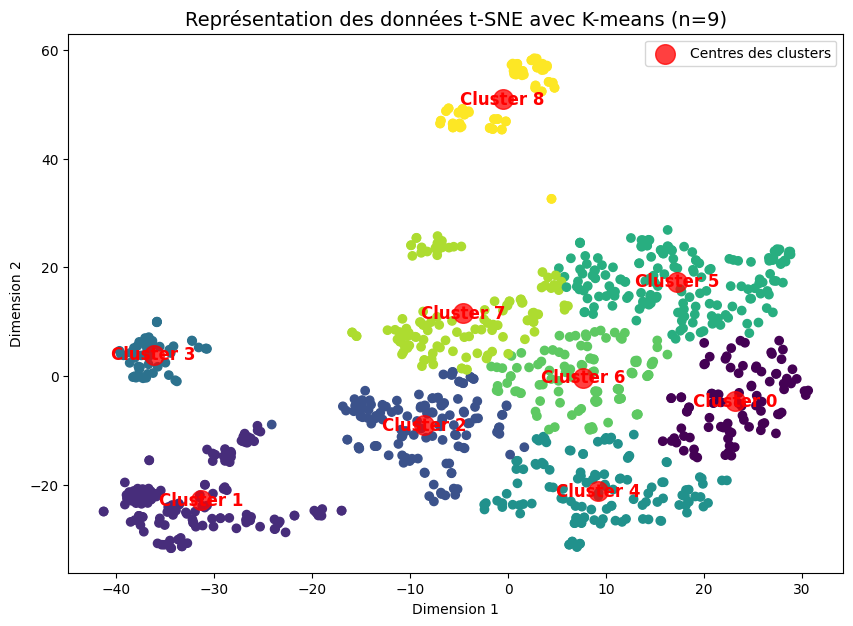

In [121]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Exécuter l'algorithme K-means sur les données réduites avec t-SNE
kmeans = KMeans(n_clusters=9, n_init=40, init='random').fit(X_tsne)
centers = kmeans.cluster_centers_  # Coordonnées des centres
labels = kmeans.labels_  # Etiquettes des clusters
df['Cluster'] = labels



# Représentation des données avec t-SNE et couleurs correspondant aux clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis')

# Ajouter les centres des clusters sur le graphe
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, label='Centres des clusters')

# Annoter les centres avec les noms des clusters
for i, center in enumerate(centers):
    plt.text(center[0], center[1], f'Cluster {i}', fontsize=12, fontweight='bold', color='red', 
             horizontalalignment='center', verticalalignment='center')

# Ajouter les titres et labels
plt.title('Représentation des données t-SNE avec K-means (n=9)', fontsize=14)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Afficher la légende
plt.legend()

# Afficher le graphe
plt.show()


Tentons de comprendre la répartition des clusters.

In [122]:
postes = ['Midfielder', 'Forward', 'Defender', 'Goalkeeper']

for post in postes:
    for i in range(0,9):
        c = ((df['position'] == post) & (df['Cluster'] == i)).sum()
        print(f"Dans le cluster {i}, il y a {c} {post}")
    print('---------------')

Dans le cluster 0, il y a 47 Midfielder
Dans le cluster 1, il y a 57 Midfielder
Dans le cluster 2, il y a 40 Midfielder
Dans le cluster 3, il y a 0 Midfielder
Dans le cluster 4, il y a 51 Midfielder
Dans le cluster 5, il y a 67 Midfielder
Dans le cluster 6, il y a 73 Midfielder
Dans le cluster 7, il y a 40 Midfielder
Dans le cluster 8, il y a 1 Midfielder
---------------
Dans le cluster 0, il y a 19 Forward
Dans le cluster 1, il y a 38 Forward
Dans le cluster 2, il y a 30 Forward
Dans le cluster 3, il y a 0 Forward
Dans le cluster 4, il y a 71 Forward
Dans le cluster 5, il y a 0 Forward
Dans le cluster 6, il y a 12 Forward
Dans le cluster 7, il y a 6 Forward
Dans le cluster 8, il y a 24 Forward
---------------
Dans le cluster 0, il y a 26 Defender
Dans le cluster 1, il y a 39 Defender
Dans le cluster 2, il y a 64 Defender
Dans le cluster 3, il y a 2 Defender
Dans le cluster 4, il y a 2 Defender
Dans le cluster 5, il y a 98 Defender
Dans le cluster 6, il y a 21 Defender
Dans le cluster 

In [128]:
scaler = StandardScaler()
df_numeric = df.select_dtypes(include=['number'])
df_stand = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)
df_stand['Cluster'] = df['Cluster']


for i in range(0,9):
    filtered_df = df_stand.loc[df_stand['Cluster'] == i]
    max_moy1=-10
    max_moy2=-10
    max_moy3=-10
    maxf1=None
    maxf2=None
    for f in filtered_df.columns:
        if f!='Cluster' and f!='minutes_played':
            moy = filtered_df[f].mean()
            if moy>max_moy1:
                max_moy1=moy
                maxf1=f
            elif moy>max_moy2:
                max_moy2=moy
                maxf2=f
    print(f"Dans le cluster {i}, la feature la plus dominante est {maxf1}, puis en 2ème c'est {maxf2}")

Dans le cluster 0, la feature la plus dominante est cross_complted, puis en 2ème c'est dribbles
Dans le cluster 1, la feature la plus dominante est yellow, puis en 2ème c'est saved_penalties
Dans le cluster 2, la feature la plus dominante est pass_accuracy, puis en 2ème c'est cross_accuracy
Dans le cluster 3, la feature la plus dominante est conceded, puis en 2ème c'est punches made
Dans le cluster 4, la feature la plus dominante est goals_per_match, puis en 2ème c'est on_target
Dans le cluster 5, la feature la plus dominante est balls_recoverd, puis en 2ème c'est tackles
Dans le cluster 6, la feature la plus dominante est cross_accuracy, puis en 2ème c'est tackles_per_match
Dans le cluster 7, la feature la plus dominante est tackles_accuracy, puis en 2ème c'est yellow
Dans le cluster 8, la feature la plus dominante est cleansheets_rate, puis en 2ème c'est outside_areas


Avec la répartition des positions et les variables clefs de chaque cluster, voici ce que nous en avons déduit : 
- cluster 0 : profil ressemblant a un joueur de couloir offensif (ailier, piston, latéral)
- cluster 1 :
- cluster 2 : profil ressemblant a des joueurs créatifs (ailier, 10, latéral)
- cluster 3 : gardiens
- cluster 4 : profil décisif (attaquant, milieu offensif)
- cluster 5 : profil beaucoup plus défensive / récupérateur (milieu défensif, défenseur)
- cluster 6 : profil ressemblant a un joueur de couloir defensif (proximité des clusters 0 et 6 sur le graphe)
- cluster 7 : profil défensive avec une bonne qualité de passe (milieu 6 8, défenseur)
- cluster 8 :

Il serait intéressant de comparer nos résultats en 2D avec des resultats qui conservent l'ensemble des dimensions. Cependant, aucunes des méthodes avec toutes les dimensions a été concluante. Il serait donc intéressant de tenter d'autres méthodes dans l'espoir de pouvoir les comparer avec nos résultats en 2D.

# GMM

Tentons maintenant une autre méthode de clustering (Gaussian Mixture Model) pour tenter d'avoir un meilleur resultat qu'avec le KMeans et la méthode hiérarchique. 

In [124]:
from sklearn.mixture import GaussianMixture

range_n_clusters = range(2,20)
best = {'score' : 0, 'n': 0}
for n in range_n_clusters:
    clusterer = GaussianMixture(n_components=n).fit(X_scaled) # GMM
    labels=clusterer.predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, labels) 
   
    # Display the results
    print("For n =", n, "Silhouette_score:", silhouette_avg)
    if best['score'] < silhouette_avg :
        best['score'] = silhouette_avg
        best['n'] = n

print(best)


For n = 2 Silhouette_score: 0.14363134860525906
For n = 3 Silhouette_score: 0.23667154090115794
For n = 4 Silhouette_score: 0.1534190401859822
For n = 5 Silhouette_score: 0.14648910335627427
For n = 6 Silhouette_score: 0.12984385339103582
For n = 7 Silhouette_score: 0.09745095703336616
For n = 8 Silhouette_score: 0.11822703574566576
For n = 9 Silhouette_score: 0.1282849052959839
For n = 10 Silhouette_score: 0.14632780142550325
For n = 11 Silhouette_score: 0.1260750304738808
For n = 12 Silhouette_score: 0.12836062589038758
For n = 13 Silhouette_score: 0.08738677475695805
For n = 14 Silhouette_score: 0.08613551378716135
For n = 15 Silhouette_score: 0.13876443483709675
For n = 16 Silhouette_score: 0.0933601892594595
For n = 17 Silhouette_score: 0.09772839318066502
For n = 18 Silhouette_score: 0.1491563221865787
For n = 19 Silhouette_score: 0.12914180215417417
{'score': 0.23667154090115794, 'n': 3}


Cette méthode a des silhouette scores inférieurs aux méthodes precedentes.

# DBSCAN

Ici, avec la méthode DBSCAN, il a été compliqué pour nous d'en tirer des resultats car il faut faire un compromis entre le silhouette score et le nombre d'outliers (données cachés).

In [125]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=5, min_samples=4)  # eps: distance max entre deux points voisins, min_samples: min points pour définir un cluster
labels = dbscan.fit_predict(X_scaled)

num_outliers = np.sum(labels == -1)
n_clusters = len(set(labels) - {-1})
print(f"Nombre de cluster : {n_clusters}")
print(f"Pourcentage des données cachés par le DBSCAN : {100*num_outliers/X_scaled.shape[0]}")

mask = labels != -1  # Masquer bruits (les outliers etiquetés -1)
df_filtered = X_scaled[mask]  # Filtrer les données
labels_filtered = labels[mask]  # Filtrer les labels


score = silhouette_score(df_filtered, labels_filtered)
print(score)

Nombre de cluster : 8
Pourcentage des données cachés par le DBSCAN : 11.665004985044865
0.2070646901592707


# Pour aller plus loin

Voici quelques idées que nous avons eu lors de l'exploration de notre data set mais que nous n'avons pas approfondi par manque de temps / compétence : 
- faire une etude avec des sous groupes de données basés sur les positions (un groupe attaquant, un groupe gardien, etc) pour ensuite faire des clusters pour permettre peut etre de voir des profils différents au sein d'un meme groupe (milieux offensifs, défensifs, ... par exemple)
- faire une etude par equipe (creer des variables a partir de sommes / moyennes tels que les buts totaux, etc) pour voir s'il n'y pas de clusters qui se forment (equipes tres offensives, tres defensives, etc)